In [2]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Configuration
# ---------------------------
ARTERIAL_FOLDER = "Arterial_side"  # folder containing arterial .wav files
VEIN_FOLDER = "Vein_side"          # folder containing vein .wav files
MODEL_PATH = "best_vae.pth"         # path to the pretrained VAE weights
SR = 44100                           # sampling rate
N_MELS = 64                          # number of Mel bands
DURATION = 5.0                       # seconds per clip
HOP_LENGTH = 512
WINDOW_LENGTH = 1024
BASELINE_DAYS = 30                   # number of initial days used for threshold calculation
THRESHOLD_K = 3.0                    # multiplier for sigma



In [4]:
# Helper functions
# ---------------------------
def extract_features(file_path, sr=SR, n_mels=N_MELS,
                     n_fft=WINDOW_LENGTH, hop_length=HOP_LENGTH,
                     duration=DURATION):
    """
    Load an audio file and compute mean Mel-spectrogram vector.
    """
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    mel = librosa.feature.melspectrogram(y=y, sr=sr,
                                         n_fft=n_fft,
                                         hop_length=hop_length,
                                         n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db.mean(axis=1)



In [5]:
# VAE model definition
# ---------------------------
class VAE(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=32, latent_dim=16):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar



In [6]:
# Load model
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=N_MELS)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device).eval()

VAE(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc_mu): Linear(in_features=32, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=64, bias=True)
  (relu): ReLU()
)

In [ ]:
records = []
# Iterate through two separate folders
for side_label, folder in [("arterial", ARTERIAL_FOLDER), ("vein", VEIN_FOLDER)]:
    if not os.path.isdir(folder):
        raise FileNotFoundError(f"Folder not found: {folder}")
    for wav_path in glob.glob(os.path.join(folder, "*.wav")):
        fname = os.path.basename(wav_path)
        base = os.path.splitext(fname)[0]  
        parts = base.split('_')
        date_raw = parts[0] 
        try:
            date = datetime.strptime(date_raw, "%Y%m%d").date()
        except ValueError:
            # skip files without proper date prefix
            continue
        feat = extract_features(wav_path)
        records.append({
            'date': date,
            'side': side_label,
            'feature': feat
        })

if not records:
    raise RuntimeError("No audio files found in specified folders.")

df = pd.DataFrame(records)
df = df.sort_values(['side', 'date']).reset_index(drop=True)


In [9]:
# Compute daily reconstruction error
# ---------------------------
mses = []
with torch.no_grad():
    for _, row in df.iterrows():
        x = torch.from_numpy(row['feature']).float().to(device)
        recon, _, _ = model(x)
        mse = ((recon - x)**2).mean().item()
        mses.append(mse)
df['mse'] = mses

In [10]:
# Thresholding and anomaly detection
# ---------------------------
results = []
for side in df['side'].unique():
    side_df = df[df['side'] == side].copy()
    baseline = side_df.head(BASELINE_DAYS)
    mu = baseline['mse'].mean()
    sigma = baseline['mse'].std()
    upper_T = mu + THRESHOLD_K * sigma
    lower_T = mu - THRESHOLD_K * sigma

    side_df['status'] = side_df['mse'].apply(
        lambda e: 'WORSE' if e > upper_T else ('BETTER' if e < lower_T else 'OK')
    )
    side_df['mu'], side_df['sigma'] = mu, sigma
    side_df['upper_T'], side_df['lower_T'] = upper_T, lower_T
    results.append(side_df)

result_df = pd.concat(results).sort_values(['side', 'date']).reset_index(drop=True)



In [11]:
# Save results
# ---------------------------
output_csv = "anomaly_results.csv"
result_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Results saved to anomaly_results.csv


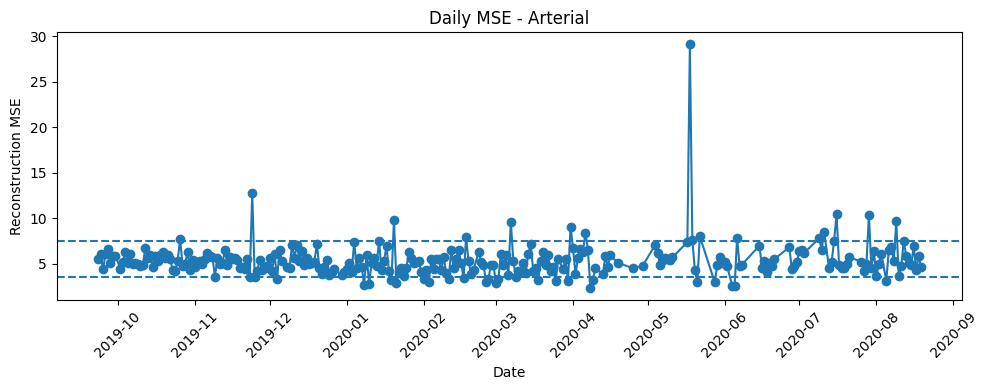

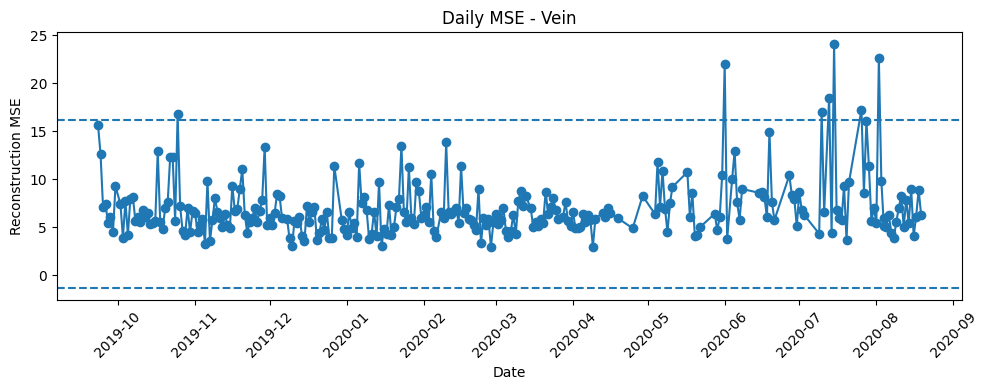

In [12]:
# Visualization
# ---------------------------
def plot_side(side_df):
    dates = side_df['date']
    mse = side_df['mse']
    upper = side_df['upper_T'].iloc[0]
    lower = side_df['lower_T'].iloc[0]

    plt.figure(figsize=(10, 4))
    plt.plot(dates, mse, marker='o', linestyle='-')
    plt.axhline(upper, linestyle='--')
    plt.axhline(lower, linestyle='--')
    plt.title(f"Daily MSE - {side_df['side'].iloc[0].capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Reconstruction MSE")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for side in result_df['side'].unique():
    plot_side(result_df[result_df['side'] == side])
